In [173]:
# Import stuff: 
from scipy.integrate import odeint, solve_ivp
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
from sympy import Symbol
from sympy.solvers import solve

# This is for reasonable fontsize universally defined:
fs_label = 16
parameters = {                
                'figure.titlesize': fs_label+6,
                'axes.labelsize': fs_label,
                'axes.titlesize': fs_label+4,
                'xtick.labelsize': fs_label,
                'ytick.labelsize': fs_label, 
                'legend.fontsize': fs_label, 
                'lines.linewidth': 5
             }
plt.rcParams.update(parameters)

names = ["Zygote", "Planula", "Cyst", "Polyp", "Medusa (juvenile)", "Medusa (mature)"]
cs = ["blue", "green", "red", "cyan", "magenta", "orange"]

xis = np.arange(0.00, 1, 0.005) # range of xi is between zero and 1 (as it is a rate)
Ts = np.arange(0, 35, 0.1) # range of temperatures is between 15 and 35


In [174]:
g = lambda d, t: (1-d)*(t-1)/t
h = lambda d, t: (1-d)/t

# Parameters: 
params_dict = dict(
    d1 = 0.8, # zygote
    d2 = 0.8, # planula
    d3 = 0.15, # cyst
    d4 = 0.45, # polyp
    d5 = 0.4, # medusa (juvenile)
    d6 = 0.5, # medusa (mature)
    t1 = 1,
    t2 = 2,
    t3 = 4,
    t4 = 4,
    t5 = 1,
    t6 = 4,
    phi = 250
)

for k, v in params_dict.items():
    assign_str = f"{k} = {v}"
    exec(assign_str)

params_dict.update(
    g1 = g(d1, t1), # zygote
    g2 = g(d2, t2), # planula
    g3 = g(d3, t3), # cyst
    g4 = (1-d4), # *(t4-1)/t4, # polyp
    #g5 = (1-d5)*(t5-1)/t5, # medusa (juvenile) # we define these inside the matrix because they need to vary with xis
    #g6 = (1-d6)*(t6-1)/t6, # medusa (mature)
    h12 = h(d1, t1), 
    h24 = h(d2, t2),  
    h34 = h(d3, t3), 
    h45 = (1-d4)*2, #/t4,  
    h53 = h(d5, t5), 
    h61 = h(d6, t6)
)

for k, v in params_dict.items():
    assign_str = f"{k} = {v}"
    exec(assign_str)
    print(assign_str)
    
def evolve(L, xis):
    ss, gr, pvs = [], [], []
    eig_values_old, eig_vectors_old = None, None
    for i, xi in enumerate(xis):

        eig_values, eig_vectors = np.linalg.eig(L(xi))
        eig_vectors = eig_vectors.T
        isort = np.argsort([abs(z) for z in eig_values])
        if i != 0:
            closest = np.array([min(eig_values, key=lambda x: np.abs(x-m)) for m in eig_values_old])
            plot_vals = closest
        else:
            plot_vals = eig_values[isort] 
        pvs.append(plot_vals)
        gr.append(eig_values[isort][-1])
        ss.append(eig_vectors[isort][-1])
        eig_values_old, eig_vectors_old = plot_vals, eig_vectors[isort]
    return ss, gr, pvs

d1 = 0.8
d2 = 0.8
d3 = 0.15
d4 = 0.45
d5 = 0.4
d6 = 0.5
t1 = 1
t2 = 2
t3 = 4
t4 = 4
t5 = 1
t6 = 4
phi = 250
g1 = 0.0
g2 = 0.09999999999999998
g3 = 0.6375
g4 = 0.55
h12 = 0.19999999999999996
h24 = 0.09999999999999998
h34 = 0.2125
h45 = 1.1
h53 = 0.6
h61 = 0.125


In [177]:
# matrix for evolution experiment
# L = lambda xi: np.array([
#     [g1,  0,   0,   0,   0,                       phi*h(d6*(1-xi), t6)*(1-xi)], 
#     [h12, g2,  0,   0,   0,                       0], 
#     [0,   0,   g3,  0,   h53*xi,                  g(d6*(1-xi), t6)*xi], 
#     [0,   h24, h34, g4,  0,                       0], 
#     [0,   0,   0,   h45, g(d5*(1-xi), t5)*(1-xi), 0], 
#     [0,   0,   0,   0,   h(d5*(1-xi), t5)*(1-xi), g(d6*(1-xi), t6)*(1-xi)] #when they get high cysting they die less?
# ])

L = lambda xi: np.array([
    [g1,  0,   0,   0,   0,                       phi*h(d6*(1-xi), t6)*(1-xi)], 
    [h12, g2,  0,   0,   0,                       0], 
    [0,   0,   g3,  0,   h(d5*(1-xi), 1)*xi,      h(d6*(1-xi), 1)*xi], # i put 1 instead of t5 and t6, bc i dont care about timestep and t5 is one 
    [0,   h24, h34, g4,  0,                       0], 
    [0,   0,   0,   h45, g(d5*(1-xi), t5)*(1-xi), 0], 
    [0,   0,   0,   0,   h(d5*(1-xi), t5)*(1-xi), g(d6*(1-xi), t6)*(1-xi)] #when they get high cysting they die less?
])

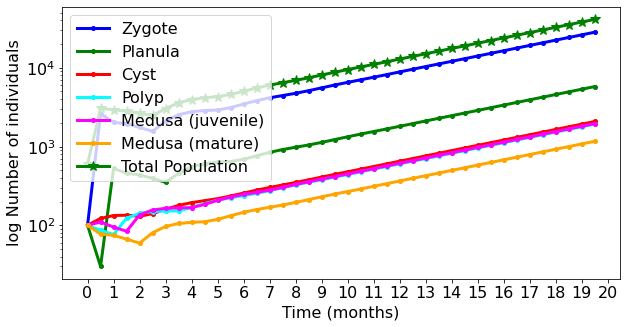

In [178]:
# plotting the population in time as an example with xi=0.4

xi = 0.4 # you can also try with xi=0.9, and the population decreases!

# getting eigen vals + vects
eig_res = np.linalg.eig(L(xi)) # calculate eigenvalues and eigenvectors and the result is a tuple of np.arrays
lams, vecs = eig_res # extract the arrays into variables

# getting only the dominatingeigen vals + corresponding eigrn vect.
id_max = max(enumerate([abs(x) for x in lams]), key=lambda x: x[1])[0] #gives index of max eigenvalue
lam_dom, vec_dom = lams[id_max], vecs[:, id_max]


def time_series(n0, t_end=10):
    ret = np.zeros((t_end, len(lams)))
    n = n0
    ret[0] = n0
    for t in range(1, t_end):
        n = np.matmul(L(xi), n)
        ret[t] = n
    return ret

# Fix time:
t_end = 40 # how many steps, each step is 15 days
t = np.arange(t_end) # make array with 40 steps
xx_ticks = np.linspace(0, 40, 21) # for plot: make array with numbers up to 40, but with 21 steps to use for x axis tick marks
xx_labels = [int(i/2) for i in xx_ticks] # for plot: make the labels for the x axis ticks

state_init = np.array([100, 100, 100, 100, 100, 100]) # set initial number of individuals for the 4 stages
sim_res = time_series(state_init, t_end=t_end) # solve the function 
pop = np.sum(sim_res, axis=1) # find total population: add the number of individuals from all stages
# growth = pop[1:]/pop[:-1] # find growth rate: divide the sum of individuals from one timestep to the next
# proportions = np.array([s/np.sum(s) for s in sim_res]) # find the proportions of each stage at each step


fig, ax = plt.subplots(figsize=(10, 5))
for i, state in enumerate(sim_res.T):
    ax.plot(t, state, label=names[i], color=cs[i], linestyle = '-', linewidth= 3, marker='o', markersize=4) 
ax.plot(t, pop, label="Total Population", color='green', marker = '*', markersize = 10, linewidth = 3)
ax.set_xticks(xx_ticks)
ax.set_xticklabels(xx_labels)
ax.legend()
#ax.legend(bbox_to_anchor=(1.0, 1), loc=2, borderaxespad=0.5, fontsize=15) 
ax.set_xlabel("Time (months)")
ax.set_ylabel("log Number of individuals")
#ax.grid(alpha = 0.5)
ax.set_yscale('log')

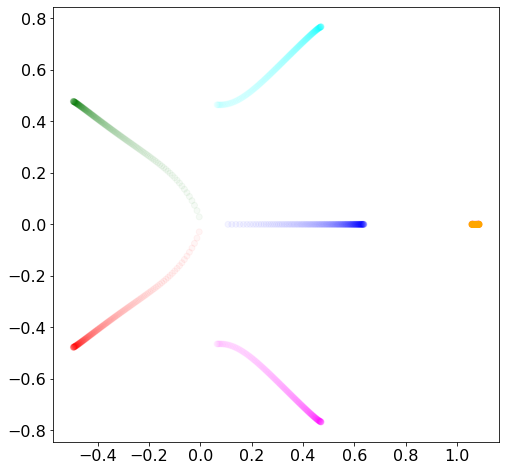

C:\Users\amabog\Anaconda3\lib\site-packages\numpy\core\_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


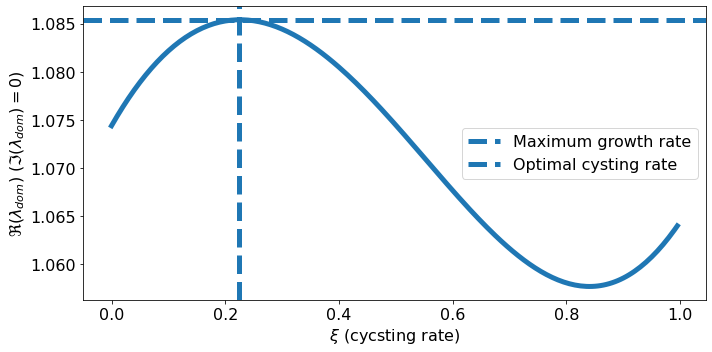

we get the maximum growth rate (1.085410038262056+0j) at cysting rate 0.225


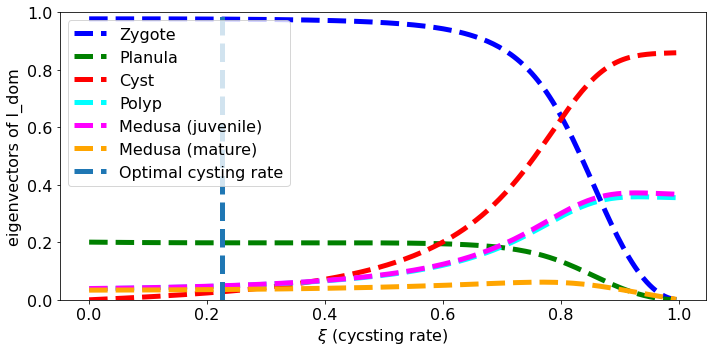

In [179]:
ss, gr, pvs = evolve(L, xis)

if True:
    fig, ax = plt.subplots(figsize=(8, 8))
    [ax.scatter(*list(zip(*[(z.real, z.imag) for z in v])), color=cs, alpha=0.04) for v in pvs]
    plt.show()
    
    fig, ax = plt.subplots(1, 1, figsize=(10, 5),sharex=True, tight_layout=True)
    ax.axhline(max(gr),linestyle="--", label = 'Maximum growth rate' )
    ax.axvline(xis[gr.index(max(gr))],linestyle="--", label = 'Optimal cysting rate' )
    ax.plot(xis, [e.real for e in gr])
    ax.set_xlabel("$\\xi$ (cycsting rate)")
    ax.set_ylabel("$\\Re(\\lambda_{{dom}})$ ($\\Im(\\lambda_{{dom}})=0$)") #charecteristic growth rate)
    ax.legend()
    plt.show()
    
    print(f'we get the maximum growth rate {max(gr)} at cysting rate {xis[gr.index(max(gr))]}')

    ss = np.array(ss)
    fig, ax = plt.subplots(1, 1, figsize=(10, 5), sharex=True, tight_layout=True)
    for i, e in enumerate(ss.T):
        ax.plot(xis, abs(e), linestyle="--", marker="", label=names[i], color=cs[i])
    ax.axvline(xis[gr.index(max(gr))],linestyle="--", label = 'Optimal cysting rate' )
    ax.set_ylim(0, 1)
    ax.set_xlabel("$\\xi$ (cycsting rate)")
    ax.set_ylabel('eigenvectors of l_dom')
    ax.legend()
    plt.show()

(0.0, 35.0)

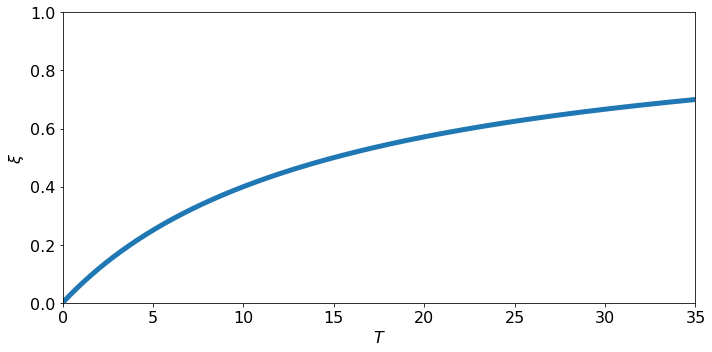

In [172]:
# # Original function for xtf, tfx
# k = 1 # this is just to use in setting the response of xi to T (and giving the correct shape to the curve)
# xft = lambda T, k=k: k*T/(T+k)
# tfx = lambda xi, k=k: k*xi/(k-xi) # this is the inverse function of xft 

# fig, ax = plt.subplots(1, 1, figsize=(7, 7), tight_layout=True)
# ax.plot(Ts, xft(Ts))
# ax.set_xlabel("$T$")
# ax.set_ylabel("$\\xi$")
# ax.set_xlim()
# ax.grid()

# fig, ax = plt.subplots(1, 1, figsize=(7, 7), tight_layout=True)
# ax.plot(xis, tfx(xis))
# ax.set_ylabel("$T$")
# ax.set_xlabel("$\\xi$")
# ax.set_ylim(0,35)
# ax.grid()

# more flat one:
k = 1 # this is just to use in setting the response of xi to T (and giving the correct shape to the curve)
s = 15 # this scales the function
xft = lambda T, k=k: k*(T/s)/((T/s)+k)
tfx = lambda xi, k=k: s*(k*xi/(k-xi)) # this is the inverse function of xft 

fig, ax = plt.subplots(1, 1, figsize=(10, 5), tight_layout=True)
ax.plot(Ts, xft(Ts))
ax.set_xlabel("$T$")
ax.set_ylabel("$\\xi$")
ax.set_ylim(0,1)
ax.set_xlim(0,35)

# # IF you want to cross check that the inverse is correct:
# fig, ax = plt.subplots(1, 1, figsize=(10, 5), tight_layout=True)
# ax.plot(xis, tfx(xis))
# ax.set_ylabel("$T$")
# ax.set_xlabel("$\\xi$")
# ax.set_xlim(0,1)
# ax.set_ylim(0,35)

In [102]:
T0 = 25 # ideal temperature for this jellyfish

(0.0, 1.0)

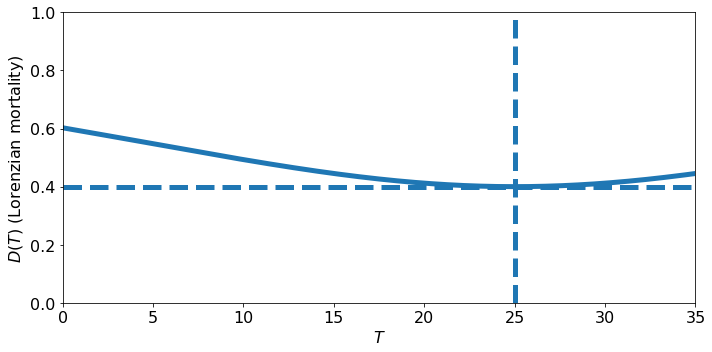

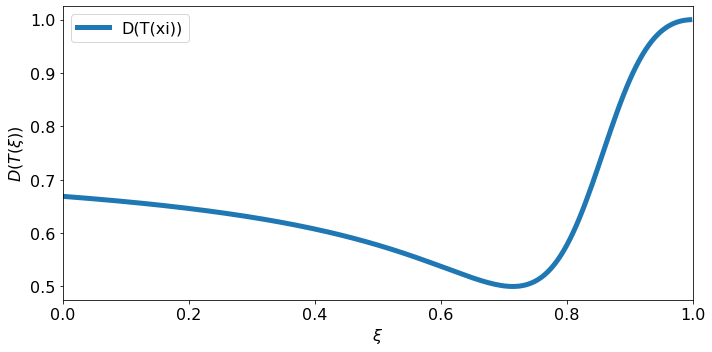

In [170]:
D = lambda d, T, T0=T0, T_half=35: d + (1-d)*(T-T0)**2/((T_half)**2+(T-T0)**2)
# what does T_half do? small T_half makes the curve steeper

fig, ax = plt.subplots(1, 1, figsize=(10, 5), tight_layout=True)
ax.axvline(T0,linestyle="--", label="Optimal temperature")
ax.axhline(0.4,linestyle="--", label = 'Background mortality' )
ax.plot(Ts, np.vectorize(D)(0.4, Ts)) # we choose as base mortality 0.5
ax.set_xlabel("$T$")
ax.set_ylabel("$D(T)$ (Lorenzian mortality)")
ax.set_xlim(0,35)
ax.set_ylim(0,1)

fig, ax = plt.subplots(1, 1, figsize=(10, 5), tight_layout=True)
ax.plot(xis, np.vectorize(D)(0.5, tfx(xis)), label="D(T(xi))")
ax.set_xlabel("$\\xi$")
ax.set_ylabel("$D(T(\\xi))$")
ax.legend()
ax.set_xlim(0,1)

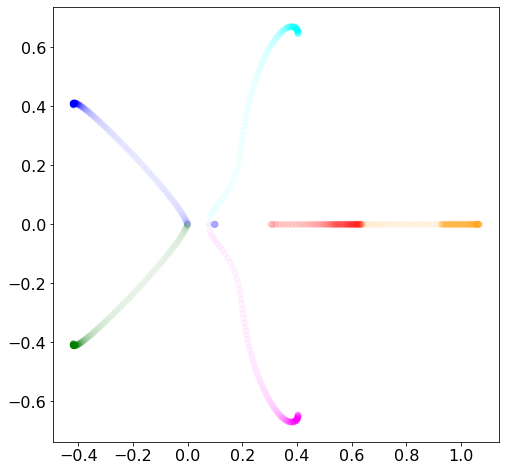

C:\Users\amabog\Anaconda3\lib\site-packages\numpy\core\_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


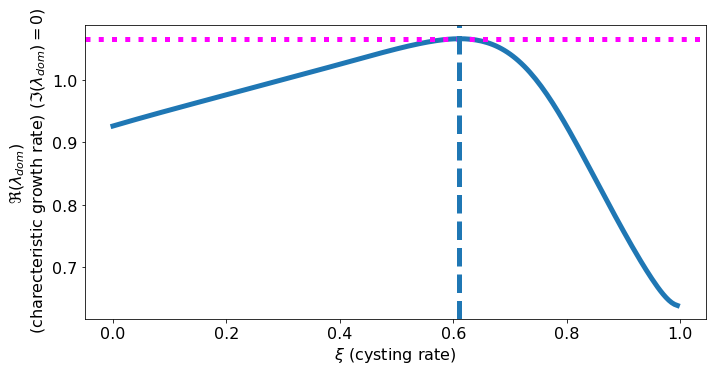

we get the maximum growth rate (1.0664333692386736+0j) at cysting rate 0.61


C:\Users\amabog\Anaconda3\lib\site-packages\numpy\core\_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


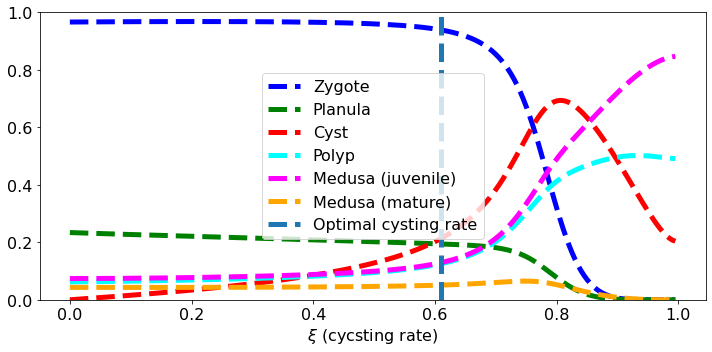

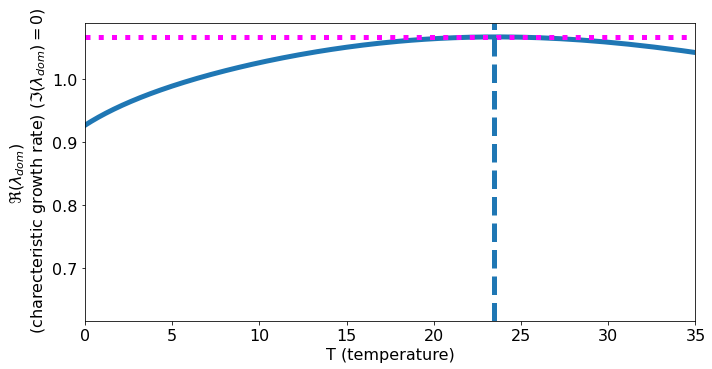

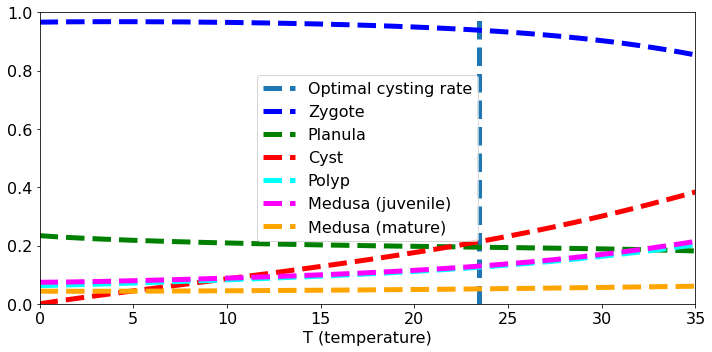

In [180]:
L = lambda xi: np.array([
    [g1,  0,   0,   0,   0,                                      phi*h(D(d6*(1-xi), tfx(xi)), t6)*(1-xi)], 
    [h12, g2,  0,   0,   0,                                      0], 
    [0,   0,   g3,  0,   h(D(d5*(1-xi), tfx(xi)), 1)*xi,        h(D(d6*(1-xi), tfx(xi)), 1)*xi], 
    [0,   h24, h34, g4,  0,                                      0], 
    [0,   0,   0,   h45, g(D(d5*(1-xi), tfx(xi)), t5)*(1-xi),    0], 
    [0,   0,   0,   0,   h(D(d5*(1-xi), tfx(xi)), t5)*(1-xi),    g(D(d6*(1-xi), tfx(xi)), t6)*(1-xi)] #when they get high cysting they die less?
])

ss, gr, pvs = evolve(L, xis)

if True:
    fig, ax = plt.subplots(figsize=(8, 8))
    [ax.scatter(*list(zip(*[(z.real, z.imag) for z in v])), color=cs, alpha=0.04) for v in pvs]
    plt.show()
    
    fig, ax = plt.subplots(1, 1, figsize=(10, 5), sharex=True, tight_layout=True)
    ax.plot(xis, [e.real for e in gr])
    ax.axhline(max(gr), linestyle=":", color="magenta", label="max growth rate")
    ax.axvline(xis[gr.index(max(gr))],linestyle="--", label = 'Optimal cysting rate' )
    ax.set_xlabel("$\\xi$ (cysting rate)")
    ax.set_ylabel("$\\Re(\\lambda_{{dom}})$ \n (charecteristic growth rate) ($\\Im(\\lambda_{{dom}})=0$)")
    plt.show()
    
    print(f'we get the maximum growth rate {max(gr)} at cysting rate {xis[gr.index(max(gr))]}')

    ss = np.array(ss)
    fig, ax = plt.subplots(1, 1, figsize=(10, 5), sharex=True, tight_layout=True)
    [ax.plot(xis, abs(e), linestyle="--", marker="", label=names[i], color=cs[i]) for i, e in enumerate(ss.T)]
    ax.axvline(xis[gr.index(max(gr))],linestyle="--", label = 'Optimal cysting rate' )
    ax.set_ylim(0, 1)
    ax.set_xlabel("$\\xi$ (cycsting rate)")
    ax.legend()

    fig, ax = plt.subplots(1, 1, figsize=(10, 5), sharex=True, tight_layout=True)
    ax.plot(tfx(xis), [e.real for e in gr])
    ax.axhline(max(gr), linestyle=":", color="magenta", label="max growth rate")
    ax.axvline(tfx(xis)[gr.index(max(gr))],linestyle="--", label = 'Optimal cysting rate' )
    ax.set_xlabel("T (temperature)")
    ax.set_ylabel("$\\Re(\\lambda_{{dom}})$ \n (charecteristic growth rate) ($\\Im(\\lambda_{{dom}})=0$)")
    ax.set_xlim(0, 35)
#     ax.set_xlim(0, 100)
    plt.show()
        
    fig, ax = plt.subplots(1, 1, figsize=(10, 5), sharex=True, tight_layout=True)
    ax.axvline(tfx(xis)[gr.index(max(gr))],linestyle="--", label = 'Optimal cysting rate' )
    [ax.plot(tfx(xis), abs(e), linestyle="--", marker="", label=names[i], color=cs[i]) for i, e in enumerate(ss.T)]
    ax.set_ylim(0, 1)
    ax.set_xlim(0, 35)
#    ax.set_xlim(0, 100)
    ax.set_xlabel("T (temperature)")
    ax.legend()
    plt.show()
    


In [9]:
len(gr)

200